<a href="https://colab.research.google.com/github/dvirchakim/dvirchakim/blob/main/%20Deep%20learning%20for%20computer%20vision%20applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep learning for computer vision applications - final hackaton


key sources :

*   https://www.kaggle.com/competitions/planttraits2024
*   https://www.kaggle.com/code/awsaf49/planttraits2024-kerascv-starter-notebook
*   DOI link: https://doi.org/10.1038/s41598-021-95616-0


This project aims to predict plant properties - so called plant traits .
Plant traits are plant properties that are used to describe how plants function how they interact with the environment
present technology opens up for us a new approch of artificial intelligence that can predict plant traits from such photographs using Convolutional Neural Networks .


the process will be as follows :

*   pre processing enviroment & Imports
*   config variables
*   read data and add image paths to dataframe
*   train and val splits
*   The heart : DNN model creation  and tunning
*   Training
*   TESTING




lets begin






###IMPORTING  DATA FROM KAGGLE :
 this sell generated automaticlly from kaggle when opend a kaggle Jupyter notebook and linkd the input to the notebook and from there outpoted to coalab for easy importing

--preferd using colab


In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'planttraits2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F65626%2F8046133%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240416%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240416T160427Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc3c13f2296c22a941ad6bd2218809d9b57f116afbc11c288efbe2a9aafd114e6406ae33869cdc5d280036809c3a6de2f814cfa54e587e19d534a88d0c4376291ff56e940b621458644fb2dc3d0e1ac017420e1863c5cbd0a9d6e948f55d957662a54071f181af6803d472bdd80aceb5eb482f40f09b08fcde5c78de37dd7673f63bd6398b89dbe1781b42da95b42797f70ae1913e9dab7b0d55debcf3ecdae826c069c5bb044a66d4a7b9c21ba81a5a8fb9262795d37fd5d7492147262eab779df2c8e43ca3e045ab518361308eafb19017703dd79affbd0a8eeecf2284b477ccbb66d0fe8b451088ae1b827914e233913913f50a5f11f1b3125a7e37ce93be3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3402840652 bytes downloaded
Downloaded and uncompressed: planttraits2024
Data source import complete.


### enviorment arranging

## preprocess

In [ ]:
#imports
import pandas as pd
import numpy as np
import random
from glob import glob
from keras.layers import Conv2D, MaxPooling2D, Flatten
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
# Load data
train = pd.read_csv('/kaggle/input/planttraits2024/train.csv')
test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')

# Drop columns ending with '_sd'
sd_columns = [col for col in train.columns if col.endswith('_sd')]
train = train.drop(columns=sd_columns)

# Define image paths
train_image_folder = '/kaggle/input/planttraits2024/train_images'
train['image_path'] = train['id'].apply(lambda x: os.path.join(train_image_folder, f"{x}.jpeg"))

test_image_folder = '/kaggle/input/planttraits2024/test_images'
test['image_path'] = test['id'].apply(lambda x: os.path.join(test_image_folder, f"{x}.jpeg"))

# Specify mean columns
mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean']

# Set destination directories for training, validation & test
path = '/kaggle/input/planttraits2024/'
os.makedirs(path, exist_ok=True)  # Create directory if it doesn't exist

# Get all images in the folders
trd = glob(path+"/train_images/*.jpeg")
ted = glob(path+"/test_images/*.jpeg")

# Print number of files in each directory
print("Training set:\n---------------")
print(f"total NORMAL training images = {len(trd)}\n")
print("Test set:\n---------------")
print(f"total NORMAL test images = {len(ted)}\n")


Training set:
---------------
total NORMAL training images = 55489

Test set:
---------------
total NORMAL test images = 7133



### ploting initial data

plants images:
-----------------


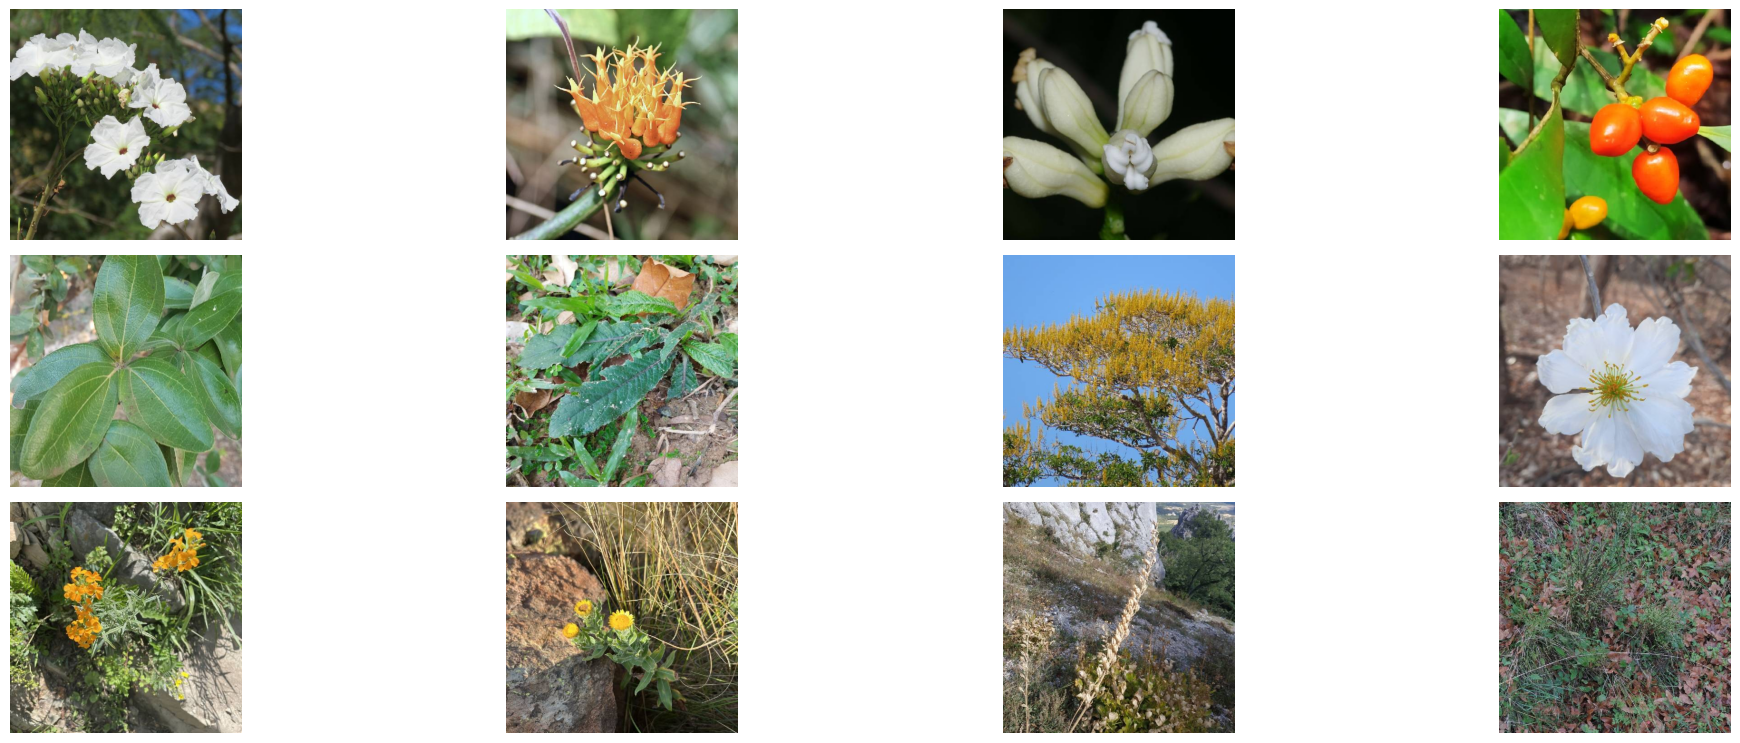

In [ ]:
# For Train images folder
plants_dir = path + '/train_images'
plants = os.listdir(plants_dir)
print("plants images:\n-----------------")
plt.figure(figsize=(20, 10))
for i in range(12):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(os.path.join(plants_dir, plants[random.randint(1,len(plants))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()

### Image processing and dataset functions

In [ ]:
import tensorflow as tf

def augment_image(img):
    # Ensure the image has the correct size before applying random crop
    img = tf.image.resize_with_crop_or_pad(img, 250, 250)  # Slightly larger than the final size
    img = tf.image.random_crop(img, size=[224, 224, 3])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    img = tf.image.random_hue(img, max_delta=0.2)
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    return img

def process_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [250, 250])  # Resize to slightly larger to allow for random cropping
        img = augment_image(img)
        # Normalize images if required by the model (uncomment the next line if necessary)
        # img = preprocess_input(img)
        return img
    except tf.errors.InvalidArgumentError:
        print(f"Error processing image: {file_path}, using a placeholder.")
        return tf.zeros([224, 224, 3])  # Return a blank image in case of error

def process_path(file_path, tabular_data, targets):
    img = process_image(file_path)
    return (img, tabular_data), targets


### Plot train data

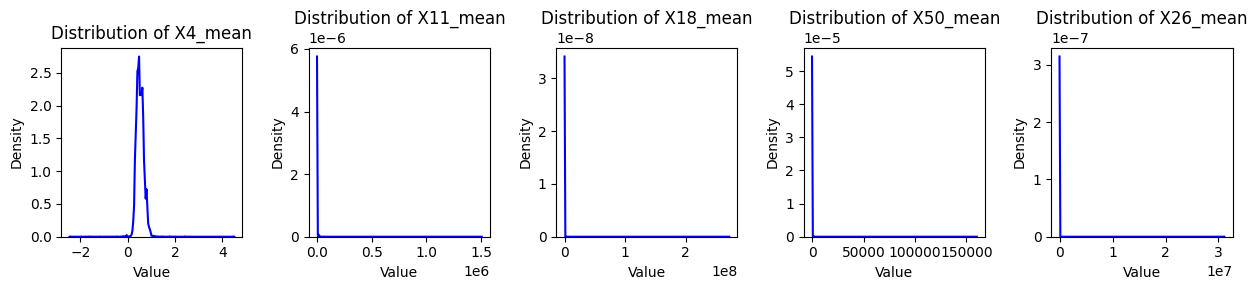

In [ ]:
def plot_data(df):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(mean_columns) // n_cols + (len(mean_columns) % n_cols > 0)

    for i, col in enumerate(mean_columns):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
plot_data(train)

we can see in the graph above that the distribution is not easy to figure so well need to make some adjusments

### Drop bad training data and Normalize target values

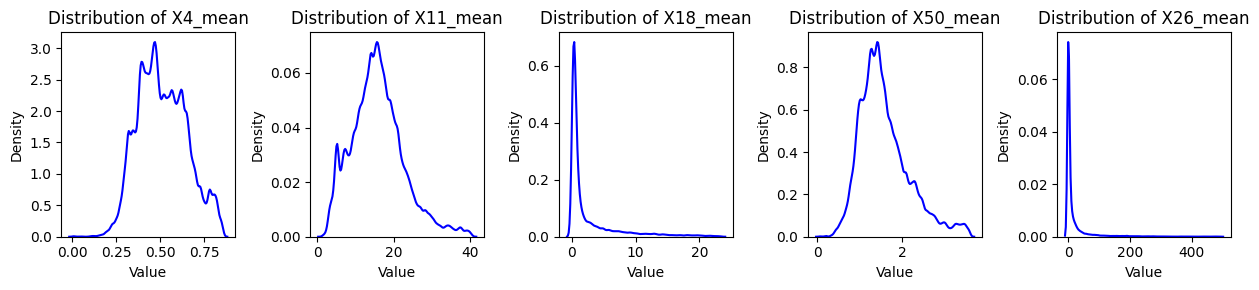

In [ ]:
for column in mean_columns:
    upper_quantile = train[column].quantile(0.98)
    train = train[(train[column] < upper_quantile)]
    train = train[(train[column] > 0)]

plot_data(train)

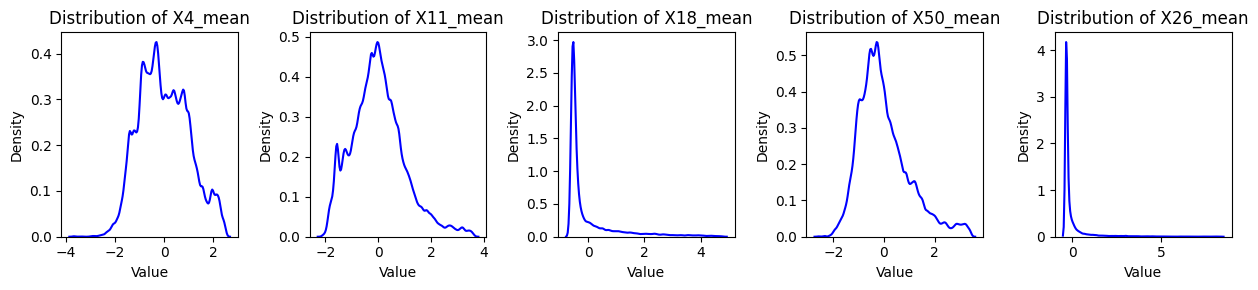

In [ ]:
original_means = {}
original_stds = {}

for column in mean_columns:
    # Calculate the mean and standard deviation for each column
    original_means[column] = train[column].mean()
    original_stds[column] = train[column].std()

    # Apply the scaling: (value - mean) / std
    # This standardizes each column to have a mean of 0 and std of 1
    train[column] = (train[column] - original_means[column]) / original_stds[column]

plot_data(train)

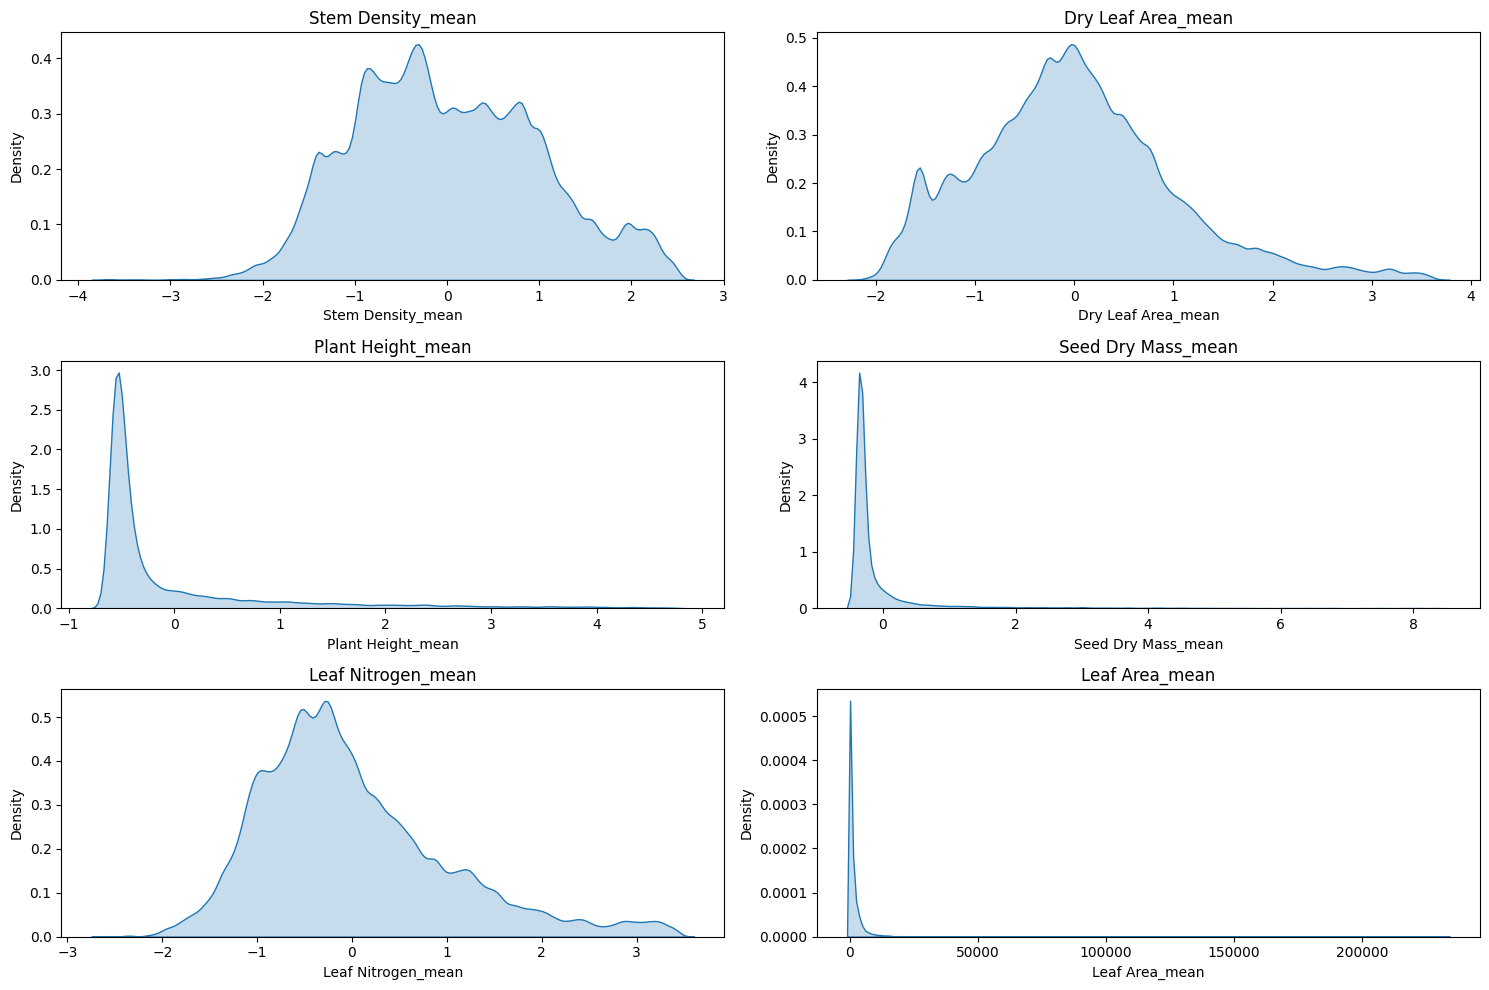

In [ ]:
mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
column_titles = {
    'X4_mean': 'Stem Density_mean',
    'X11_mean': 'Dry Leaf Area_mean',
    'X18_mean': 'Plant Height_mean',
    'X26_mean': 'Seed Dry Mass_mean',
    'X50_mean': 'Leaf Nitrogen_mean',
    'X3112_mean': 'Leaf Area_mean'
}

def plot_data(df, mean_columns, column_titles):
    plt.figure(figsize=(15, 10))
    n_cols = 2
    n_rows = len(mean_columns) // n_cols + (len(mean_columns) % n_cols > 0)

    for i, col in enumerate(mean_columns):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=True)
        plt.title(column_titles[col])
        plt.xlabel(column_titles[col])
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

plot_data(train, mean_columns, column_titles)


In [ ]:
# Remove rows with any missing values
train_data_cleaned = train.dropna()
test_data_cleaned = test.dropna()
# Display the new shape of the dataset to see how many rows were dropped
print(test_data_cleaned.shape)
print(train_data_cleaned.shape)

(6545, 165)
(50010, 171)


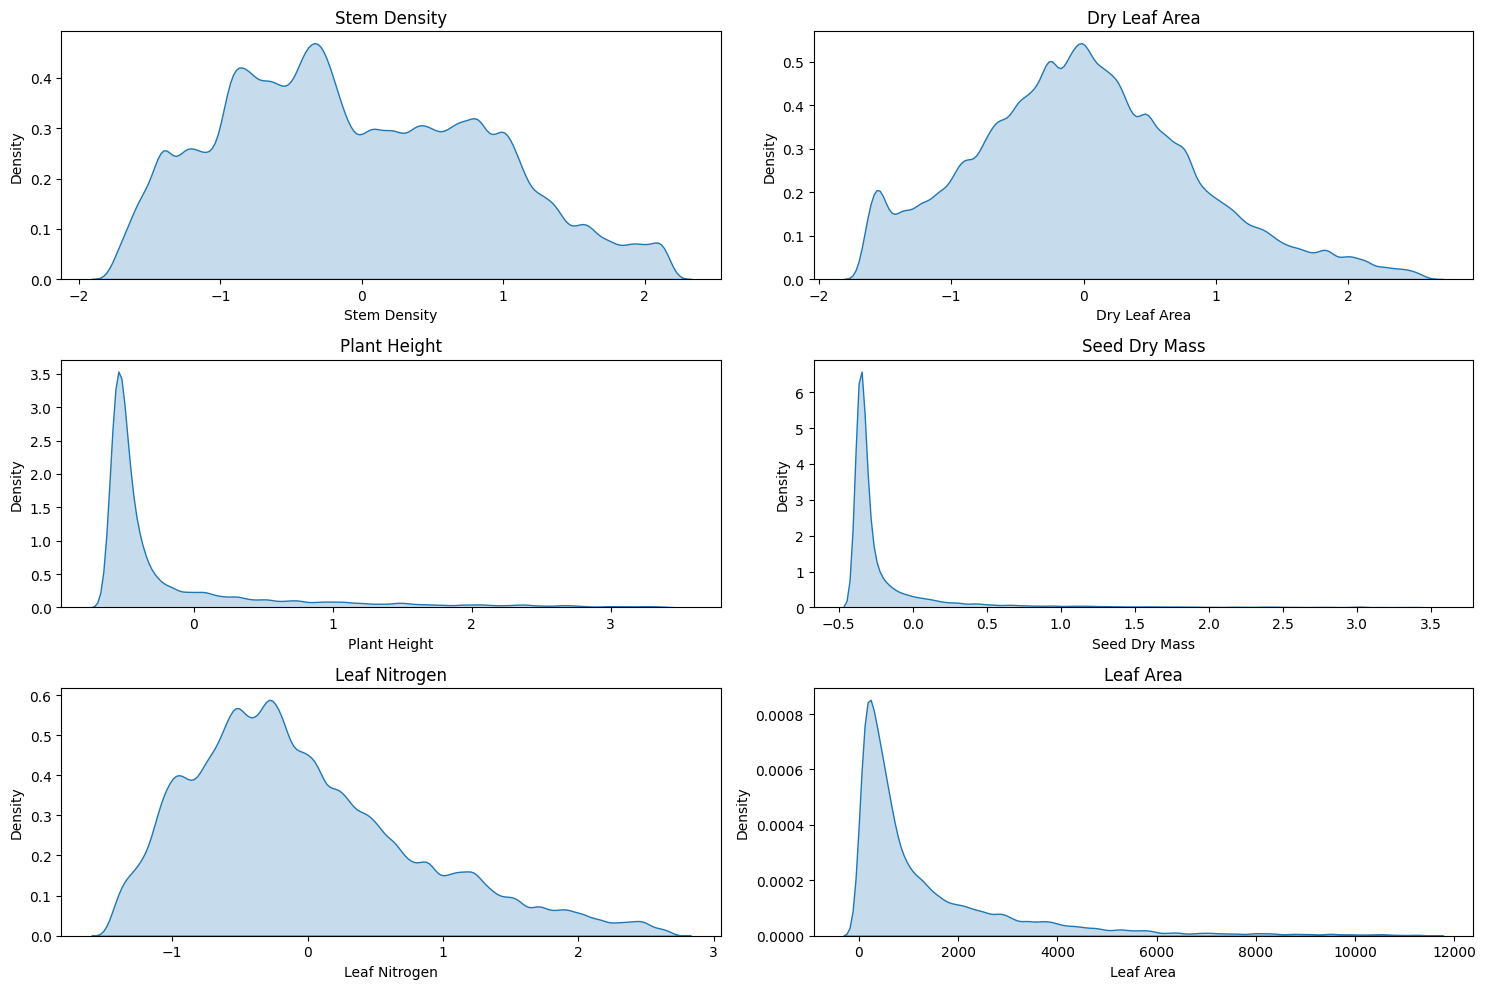

In [ ]:
mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean','X3112_mean']
column_titles = {
    'X4_mean': 'Stem Density',
    'X11_mean': 'Dry Leaf Area',
    'X18_mean': 'Plant Height',
    'X26_mean': 'Seed Dry Mass',
    'X50_mean': 'Leaf Nitrogen',
    'X3112_mean': 'Leaf Area'
}
for column in mean_columns:
    upper_quantile = train[column].quantile(0.98)  # Calculate the 98th percentile
    lower_quantile = train[column].quantile(0.02)  # Calculate the 2nd percentile
    # Filter out the rows where column values are below the 2nd or above the 98th percentile
    train = train[(train[column] < upper_quantile) & (train[column] > lower_quantile)]

# After filtering, plot the data using the plot_data function
plot_data(train, mean_columns, column_titles)


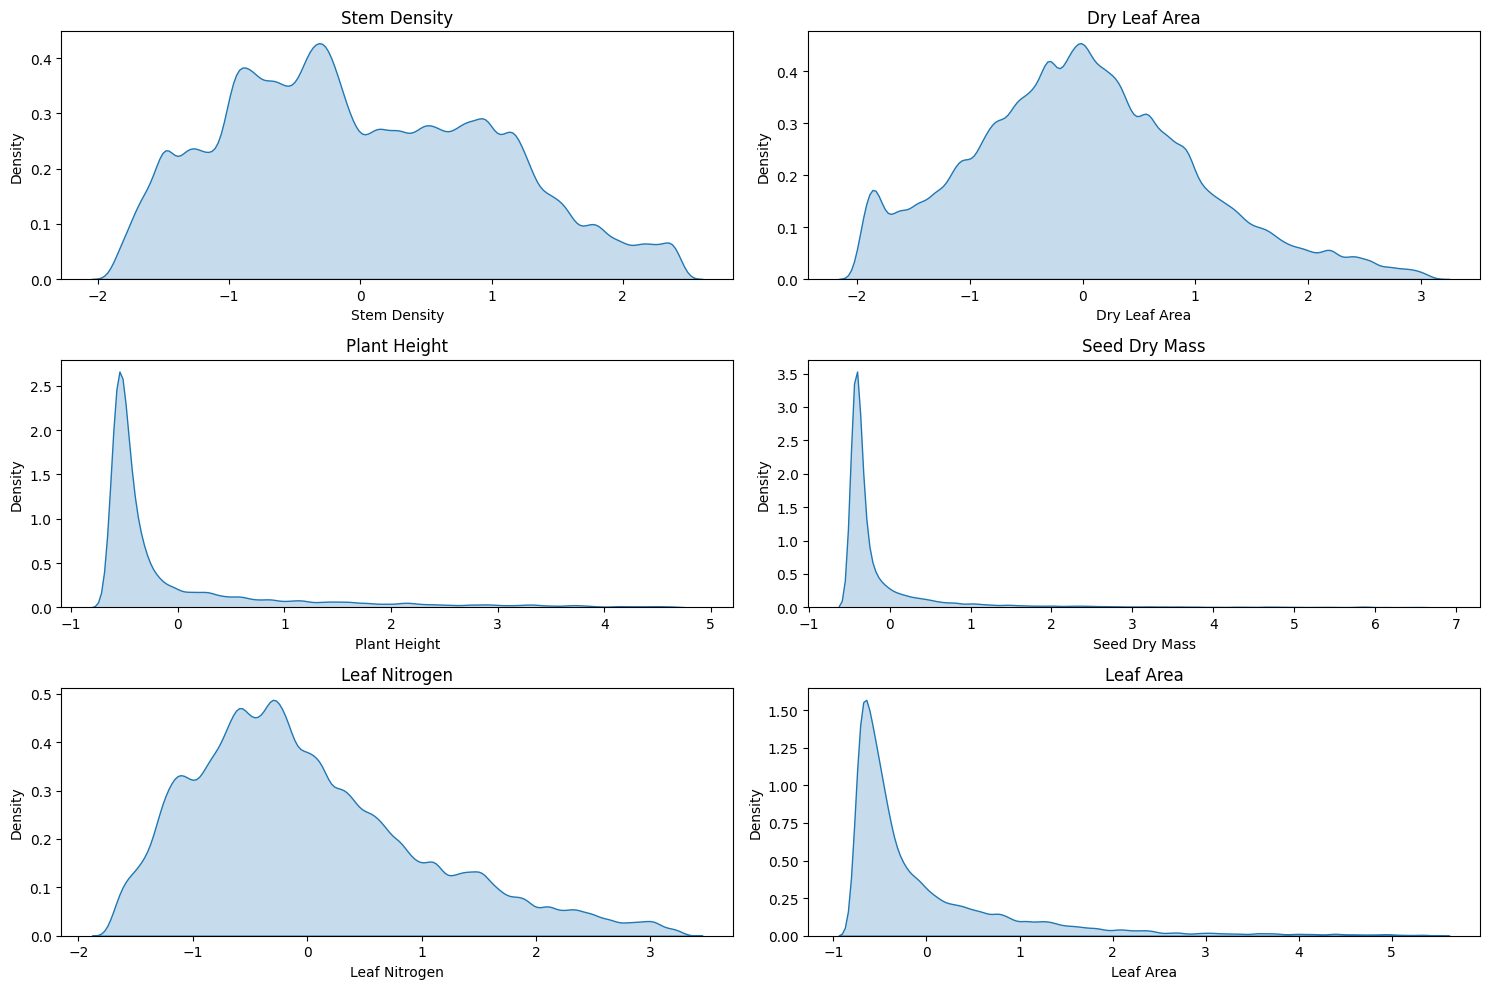

In [ ]:
original_means = {}
original_stds = {}

for column in mean_columns:
    # Calculate the mean and standard deviation for each column
    original_means[column] = train[column].mean()
    original_stds[column] = train[column].std()

    # Apply the scaling: (value - mean) / std
    # This standardizes each column to have a mean of 0 and std of 1
    train[column] = (train[column] - original_means[column]) / original_stds[column]

# Make sure to pass the 'mean_columns' and 'column_titles' when you call 'plot_data'
plot_data(train, mean_columns, column_titles)


### Normalize tabular inputs

In [ ]:
x = train.drop(columns=['id', 'image_path'] + mean_columns)

for column in x.columns:
    min_val = x[column].min()
    max_val = x[column].max()
    x[column] = (x[column] - min_val) / (max_val - min_val)

## Create train and validation sets

In [ ]:
y = train[mean_columns]
x_paths = train['image_path']

train_tabular, val_tabular, train_targets, val_targets = train_test_split(
    x, y, test_size=0.2, random_state=42)

train_paths, val_paths = train_test_split(
    x_paths, test_size=0.2, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_tabular.to_numpy(), train_targets.to_numpy()))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_tabular.to_numpy(), val_targets.to_numpy()))

# Apply the processing function
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

## Define model

In [ ]:
# Image model pathway
image_input = Input(shape=(224, 224, 3))
# Instantiate EfficientNet with no top and no pooling to keep spatial dimensions
effnet_layer = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=image_input, pooling=None)

# Unfreeze the top layers of the model
for layer in effnet_layer.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Adding convolutional layers directly after EfficientNet output
x = Conv2D(32, (3, 3), padding='same')(effnet_layer.output)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Apply Global Average Pooling after new conv layers
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# Tabular model pathway
tabular_input = Input(shape=(train_tabular.shape[1],))
tabular_dense = Dense(512, activation='relu')(tabular_input)
tabular_dense = Dropout(0.5)(tabular_dense)

# Concatenate both pathways
concat = Concatenate()([x, tabular_dense])
concat_dense = Dense(256, activation='relu')(concat)
concat_dense = Dropout(0.5)(concat_dense)

# Output layer
output = Dense(len(mean_columns), activation='linear')(concat_dense)  # Assuming 'mean_columns' is defined elsewhere

model = Model(inputs=[image_input, tabular_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

model.summary()

model


16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

## train with early stopping

In [ ]:
# Create an EarlyStopping callback instance
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    min_delta=0.01,        # Minimum change to qualify as an improvement
    patience=10,            # How many epochs to wait before stopping
    restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric

# Create a ReduceLROnPlateau callback instance
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001)

# Combine callbacks in a list
callbacks_list = [early_stopping, reduce_lr]

# Assuming you have already defined your model, data, etc.
# Fit the model with the callbacks
history = model.fit(
    train_ds,  # Training data
    validation_data=val_ds,  # Validation data
    epochs=50,  # Number of epochs
    callbacks=callbacks_list)  # Add the callbacks list here


Epoch 1/50
979/979 [==============================] - 159s 116ms/step - loss: 0.9243 - mae: 0.6960 - val_loss: 0.8250 - val_mae: 0.6413 - lr: 1.0000e-04
Epoch 2/50
979/979 [==============================] - 110s 112ms/step - loss: 0.8403 - mae: 0.6556 - val_loss: 0.8024 - val_mae: 0.6327 - lr: 1.0000e-04
Epoch 3/50
979/979 [==============================] - 110s 112ms/step - loss: 0.8128 - mae: 0.6413 - val_loss: 0.7924 - val_mae: 0.6347 - lr: 1.0000e-04
Epoch 4/50
979/979 [==============================] - 110s 112ms/step - loss: 0.7910 - mae: 0.6308 - val_loss: 0.7832 - val_mae: 0.6184 - lr: 1.0000e-04
Epoch 5/50
979/979 [==============================] - 110s 112ms/step - loss: 0.7727 - mae: 0.6222 - val_loss: 0.7834 - val_mae: 0.6206 - lr: 1.0000e-04
Epoch 6/50
979/979 [==============================] - 109s 111ms/step - loss: 0.7548 - mae: 0.6139 - val_loss: 0.7782 - val_mae: 0.6133 - lr: 1.0000e-04
Epoch 7/50
979/979 [==============================] - 109s 112ms/step - loss: 0.73

In [ ]:
model.save_weights("model.weights.h5")

In [ ]:
# Prepare tabular data (excluding 'id' and 'image_path')
test_tabular = test.drop(columns=['id', 'image_path'])

#normalize tabular data
for column in test_tabular.columns:
    min_val = test_tabular[column].min()
    max_val = test_tabular[column].max()
    test_tabular[column] = (test_tabular[column] - min_val) / (max_val - min_val)

In [ ]:
column_titles = {
 'X4_mean': 'Stem Density',
 'X11_mean': 'Dry Leaf Area',
 'X18_mean': 'Plant Height',
 'X26_mean': 'Seed Dry Mass',
 'X50_mean': 'Leaf Nitrogen',
 'X3112_mean': 'Leaf Area'
}

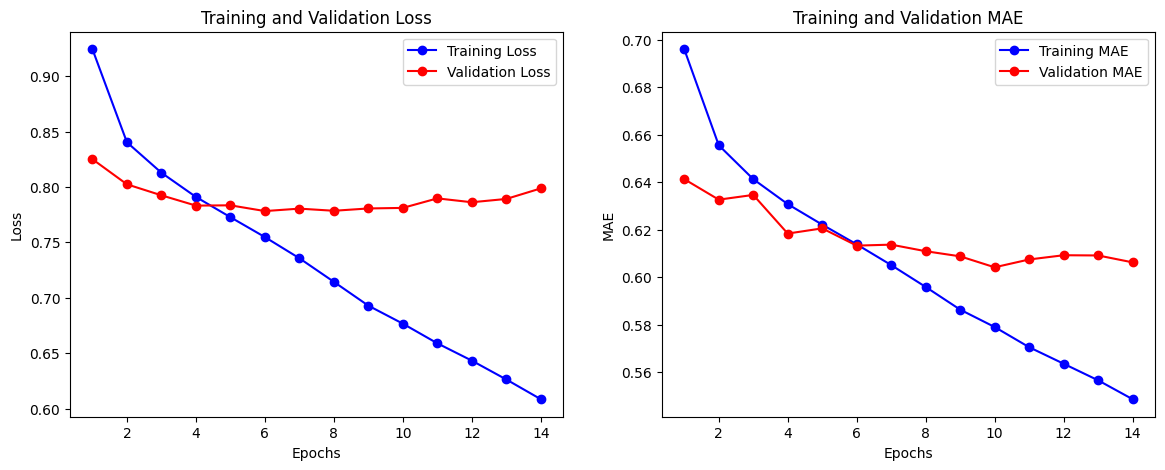

In [ ]:
# Extract the history records
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

# Plotting the loss and MAE
plt.figure(figsize=(14, 5))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


## test

In [ ]:
import tensorflow as tf
import pandas as pd

# Assume process_image is defined to preprocess images
# Assume test contains 'image_path' and test_tabular contains the tabular data

# Convert tabular data to numpy array
test_tabular_np = test_tabular.to_numpy()

# Create a dataset for images
test_images_ds = tf.data.Dataset.from_tensor_slices(test['image_path'])
test_images_ds = test_images_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

# Create a dataset for tabular data
test_tabular_ds = tf.data.Dataset.from_tensor_slices(test_tabular_np)

# Combine datasets into one, formatting correctly for the model
test_ds = tf.data.Dataset.zip((test_images_ds, test_tabular_ds))
test_ds = test_ds.map(lambda x, y: ((x, y),))  # Ensure the input structure matches what the model expects

# Batch the dataset
test_ds_batched = test_ds.batch(32)

# Predict using the model
predictions = model.predict(test_ds_batched)

# Assuming 'model' outputs numpy array, convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Stem Density', 'Dry Leaf Area', 'Plant Height', 'Seed Dry Mass', 'Leaf Nitrogen', 'Leaf Area'])

# Concatenate predictions with the original test data, if necessary
final_results = pd.concat([test.reset_index(drop=True), predictions_df], axis=1)

# Display or save the final results
print(final_results.head())


205/205 [==============================] - 8s 32ms/step
          id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  201238668                                8.086756   
1  202310319                               10.844286   
2  202604412                                8.105556   
3  201353439                                7.077679   
4  195351745                                4.790555   

   WORLDCLIM_BIO12_annual_precipitation  \
0                           2246.500000   
1                            495.871429   
2                            378.328583   
3                            878.785706   
4                           2299.366699   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                         127.321426                       
1                                          28.023809                       
2                                          39.928570                       
3                                          7

ValueError: num must be an integer with 1 <= num <= 6, not 7

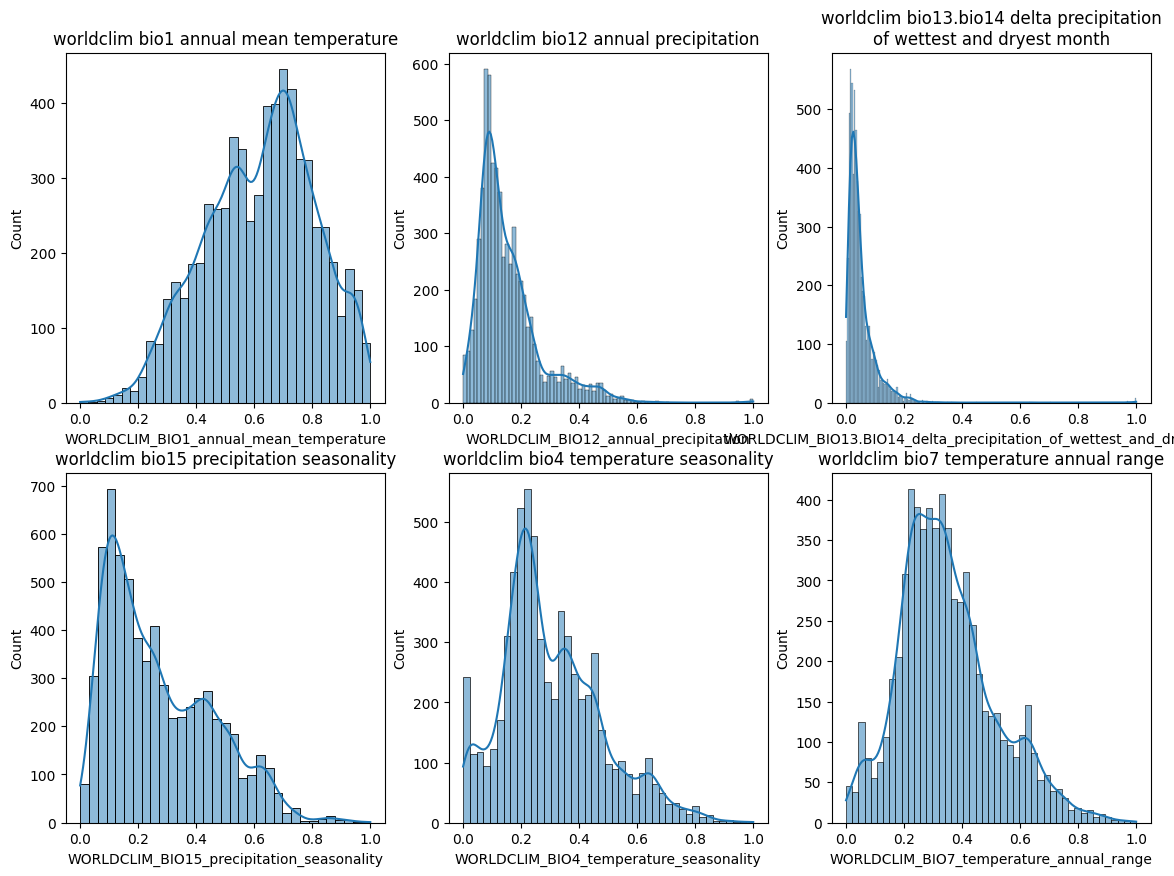

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to split title into two rows if longer than 5 words
def split_title(title):
    words = title.split()
    if len(words) > 5:
        half = len(words) // 2
        return ' '.join(words[:half]) + '\n' + ' '.join(words[half:])
    else:
        return title

# Histograms for tabular data
plt.figure(figsize=(14, 10))
for i, column in enumerate(test_tabular.columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(test_tabular[column], kde=True)
    title = split_title(column.replace("_", " ").lower())
    plt.title(title)
plt.suptitle('Tabular Data Distribution', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

# Scatter plots for tabular data (pairwise)
plt.figure(figsize=(14, 14))
sns.pairplot(test_tabular)
plt.suptitle('Pairwise Relationships of Tabular Data', fontsize=16)
plt.subplots_adjust(hspace=0.5)
plt.show()

# Scatter plots for tabular data vs. predictions
plt.figure(figsize=(14, 10))
for i, column in enumerate(test_tabular.columns):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=test_tabular[column], y=predictions_df.iloc[:, i])
    plt.xlabel(column.replace("_", " ").lower())
    plt.ylabel('Predicted ' + predictions_df.columns[i].replace("_", " ").lower())
    title = split_title('Tabular Data vs. Predictions')
    plt.title(title)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()


ValueError: num must be an integer with 1 <= num <= 6, not 7

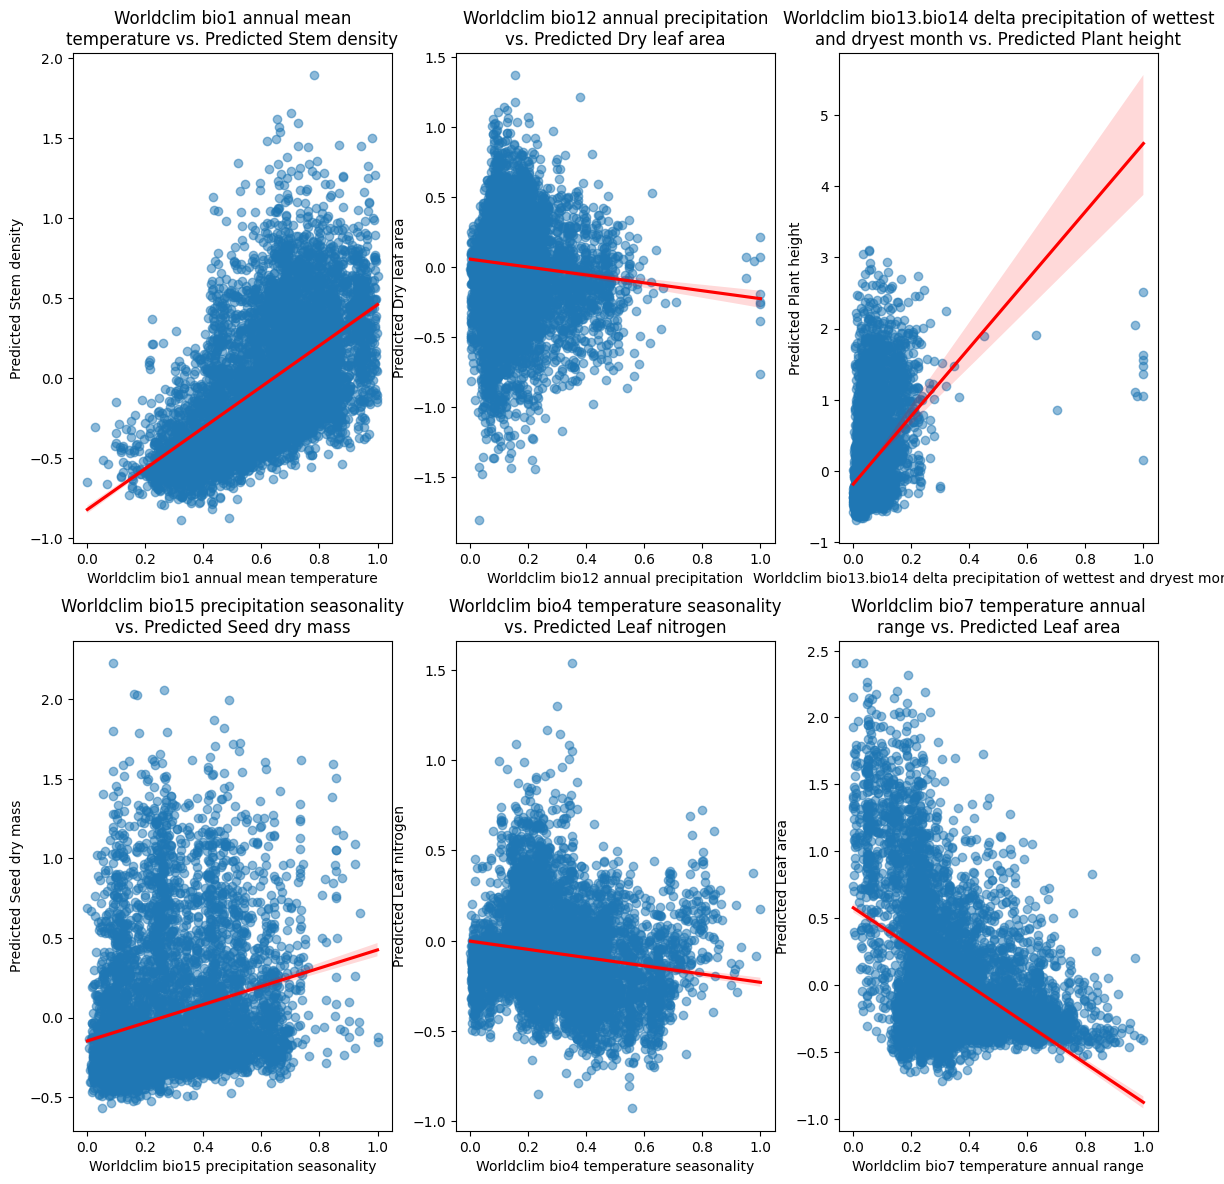

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to split title into two rows if longer than 5 words
def split_title(title):
    words = title.split()
    if len(words) > 5:
        half = len(words) // 2
        return ' '.join(words[:half]) + '\n' + ' '.join(words[half:])
    else:
        return title

# Assuming 'predictions_df' contains the predictions for the same indices as 'test_tabular'
plt.figure(figsize=(14, 14))
for i, column in enumerate(test_tabular.columns):
    plt.subplot(2, 3, i+1)  # Adjust the subplot grid if necessary based on the number of features
    sns.regplot(x=test_tabular[column], y=predictions_df.iloc[:, i], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.xlabel(column.replace("_", " ").capitalize())  # Improved label formatting
    plt.ylabel('Predicted ' + predictions_df.columns[i].replace("_", " ").capitalize())
    title = split_title(column.replace("_", " ").capitalize() + ' vs. Predicted ' + predictions_df.columns[i].replace("_", " ").capitalize())
    plt.title(title)
plt.suptitle('Regression Plots: Actual vs. Predicted', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()
